<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Things" data-toc-modified-id="Import-Things-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Things</a></span></li><li><span><a href="#Anonymous-Funcitons" data-toc-modified-id="Anonymous-Funcitons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Anonymous Funcitons</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Named Functions</a></span></li><li><span><a href="#Get-Geometry" data-toc-modified-id="Get-Geometry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Geometry</a></span></li><li><span><a href="#Compare-to-Literature" data-toc-modified-id="Compare-to-Literature-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare to Literature</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#NOTE" data-toc-modified-id="NOTE-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>NOTE</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

# Import Things

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import matplotlib.gridspec
from scipy.stats import sem

sns.set()

with open("tidy_data/geometry_data.pkl","rb") as file_in:
    raw_data = pkl.load(file_in)
    
raw_df = pd.DataFrame(raw_data)


raw_df.head()

,A,B,angles,bonds,fill,system
0,NaN,0,[105.36368698502989],"[0.973000878290579, 0.9730088347812262]",1000,beryl
1,NaN,1,[105.35087075683664],"[0.972962025117793, 0.9729614079942821]",1000,beryl
2,NaN,10,[105.34794212312683],"[0.9730240372869534, 0.9729868500532556]",1000,beryl
3,NaN,11,[105.51502522374619],"[0.9724294901907392, 0.9727270373876404]",1000,beryl
4,NaN,12,[105.31514572601299],"[0.9729075432648405, 0.9731076619050572]",1000,beryl


# Anonymous Funcitons

In [2]:
filter_by_system = lambda sys,df=raw_df: df[df.system==sys]
filter_by_fill = lambda fill,df=raw_df: df[df.fill==str(fill)]
flatten = lambda l: [j for i in l for j in i]
#get_stats = lambda bd,an: [np.mean(bd),np.std(bd)/np.sqrt(len(bd)),np.mean(an),np.std(an)/np.sqrt(len(an))]
get_stats = lambda bd,an: [np.mean(bd),sem(bd),np.mean(an),sem(an)]

# Named Functions


In [3]:
def get_combined_errors(sys):
    # These results come from combining the averages and variances correctly. Done by hand
    if sys == "beryl":
        b = 0.97294
        a= 105.193
        b_err = 0.00004
        a_err = 0.012
    else:
        b = 0.97219
        a = 104.36
        b_err = 0.00005
        a_err = 0.014
    return b, b_err, a, a_err

def get_geometry_data(sys):
    in_df = filter_by_system(sys,df=raw_df)
    fills = in_df.fill.unique().tolist()
    results_df = pd.DataFrame(columns="bond_avg bond_err angle_avg angle_err".split())
    for fill in fills:
        df = filter_by_fill(fill,df=in_df)
        bonds = flatten(df.bonds.values)
        angles = flatten(df.angles.values)
        results_df.loc[fill] = get_stats(bonds,angles)

    results_df['fill'] = [25,50,50,75,100]

    results_df.head()
    b, b_e, a, a_e = get_combined_errors(sys)

    #Take the average of the two 50% fills.

    merged_results_df = results_df.append(results_df[results_df.fill == 50].mean(axis=0),ignore_index=True)
    merged_results_df.iloc[5,0] = b
    merged_results_df.iloc[5,2] = a
    merged_results_df.iloc[5,1] = b_e
    merged_results_df.iloc[5,3] = a_e   
    merged_results_df.drop([1,2],axis=0,inplace=True)
    merged_results_df.fill.apply(int)
    merged_results_df.sort_values("fill",inplace=True)

    return merged_results_df


def make_plot():
    sns.set(font_scale=1.5)
    gs = matplotlib.gridspec.GridSpec(2,1)
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Geometry Optimization Results",fontsize=20)
    ax1 = plt.subplot(gs[0,0])
    ax1.errorbar(beryl_results_df.fill.values,beryl_results_df.bond_avg.values,
                 yerr=beryl_results_df.bond_err.values,label="Beryl")
    ax1.errorbar(vacuum_results_df.fill.values,vacuum_results_df.bond_avg.values,
                 yerr=vacuum_results_df.bond_err.values,label="Vacuum")
    sns.lineplot(x="fill",y="bond",data=lit_df.beryl,ax=ax1,label="Lit. Vacuum")
    sns.lineplot(x="fill",y="bond",data=lit_df.vacuum,ax=ax1,label="Lit. Beryl")
    ax2 = plt.subplot(gs[1,0])
    ##sns.lineplot(data=merged_results_df,x="fill",y="angle_avg",ax=ax2)
    ax2.errorbar(beryl_results_df.fill.values,beryl_results_df.angle_avg.values,
                 yerr=beryl_results_df.angle_err.values,label="Beryl")
    ax2.errorbar(vacuum_results_df.fill.values,vacuum_results_df.angle_avg.values,
                 yerr=vacuum_results_df.angle_err.values,label="Vacuum")
    sns.lineplot(x="fill",y="angle",data=lit_df.beryl,ax=ax2,label="Lit. Beryl")
    sns.lineplot(x="fill",y="angle",data=lit_df.vacuum,ax=ax2,label="Lit. Vacuum")
    
    ax1.set(ylabel="Bond [Ang]")
    ax2.set(ylabel="Angle [Deg]")
    ax2.set(xlabel="Fill [%]")
    ax1.legend(fontsize=12)
    ax2.legend(fontsize=12)

# Get Geometry

In [4]:
beryl_results_df = get_geometry_data("beryl")
vacuum_results_df = get_geometry_data("vacuum") 



In [5]:
beryl_results_df

,bond_avg,bond_err,angle_avg,angle_err,fill
0,0.972980,0.000029,105.352569,0.008699,25.0
5,0.972940,0.000040,105.193000,0.012000,50.0
3,0.973134,0.000039,105.085020,0.012542,75.0
4,0.973222,0.000064,104.805719,0.025302,100.0


In [6]:
vacuum_results_df

,bond_avg,bond_err,angle_avg,angle_err,fill
0,0.972124,0.000008,104.397901,0.004899,25.0
5,0.972190,0.000050,104.360000,0.014000,50.0
3,0.972283,0.000068,104.184631,0.025955,75.0
4,0.972519,0.000086,104.158806,0.023958,100.0


# Compare to Literature

Here, the literature values are compared to [this work](https://aip.scitation.org/doi/10.1063/1.4882062). In that study, the crystal geometry was fixed to an experimental structure to compare the computational results to the experimental ones.



In [7]:
lit_values = {'beryl': {"bond":[0.973,0.973],"angle":[105.07,104.59],"fill":[50,100]},
              'vacuum': {"bond":[0.972,0.972],"angle":[104.39,104.33],"fill":[50,100]}}
lit_df = pd.DataFrame(lit_values)
lit_df.head()


,beryl,vacuum
angle,"[105.07, 104.59]","[104.39, 104.33]"
bond,"[0.973, 0.973]","[0.972, 0.972]"
fill,"[50, 100]","[50, 100]"


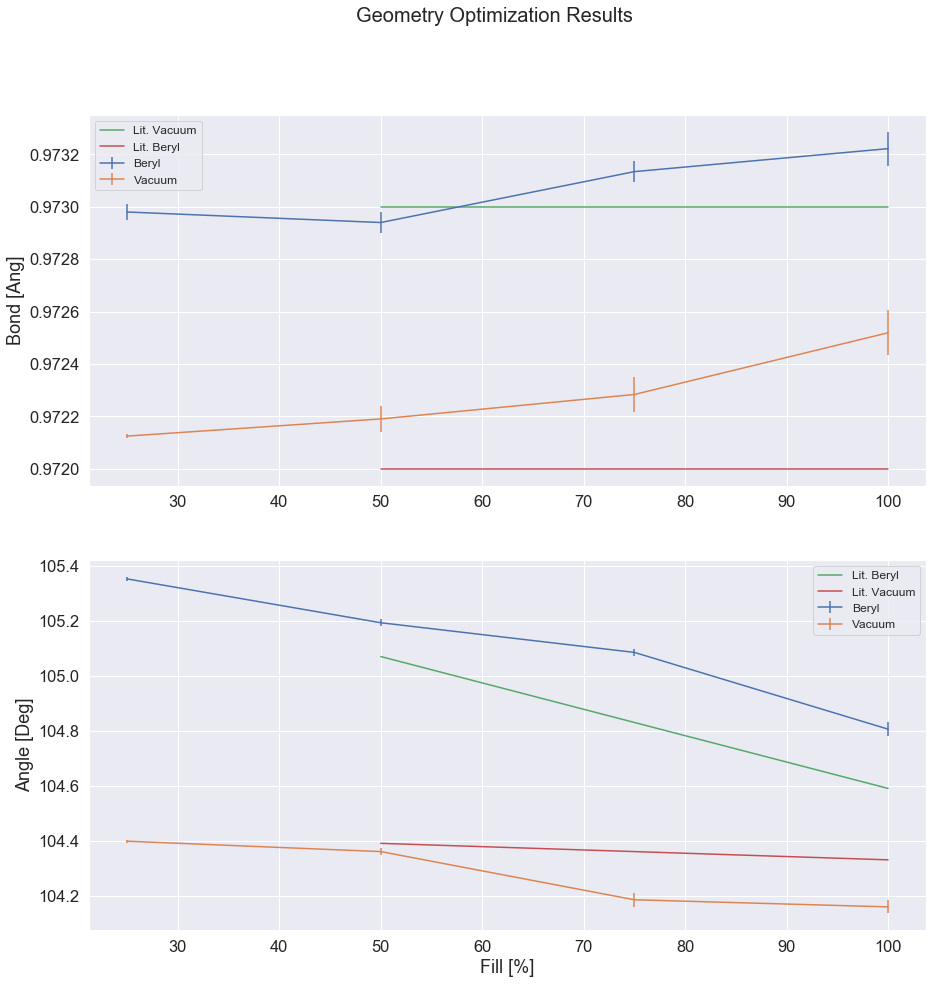

In [8]:
make_plot()

### NOTE

The error comes from the standard error of the mean.

# Conclusion

1. Good agreement with literature
    - Especially considering they used a smaller unit cell
2. Crystal affect geoemtry
    - "Expands" water molcule 
3. Use fill specific geometry moving forward

Deviations from trends at 50% fill likely due to 2-fold degeneracy. As unit cell becomes larger, and so does this degeneracy, the aggregate values should come in line more with trends.